# ReSurfEMG: a Python package for comprehensive analysis of respiratory surface EMG


### Note
This notebook is adapted to run on ReSurfEMG 1.1.0 to improve forward compatability and re-use. As compared to ReSurfEMG 1.0.2, with which the analysis for the paper was conducted, this mainly includes refactoring of methods and no signal analytical adapations:
- Signal indexing: TimeSeries.y_raw -->   TimeSeries['raw]
- Convert signal_type to signal_io arguments: signal_type='raw' -->   signal_io=('raw', 'filt')
- Split gating and wavelet_denoising in ECG peak detection (.get_ecg_peaks) and ECG removal (.gating, .wavelet_denoising)

# 1. Import the required libraries

In [1]:
# Standard code libraries
import os
import platform
import glob

import numpy as np
from numpy.matlib import repmat
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Custom code libraries from ReSurfEMG
from resurfemg.data_connector.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the ventilator and sEMG data

In [2]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()

# Then find the files for the selected patients:
base_path = config.get_directory('test_data')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='emg_data_synth_pocc',
    extension_regex='poly5',
    folder_levels=None)

folder_levels = ['date', 'measurement']
vent_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='vent_data_synth_pocc',
    extension_regex='poly5',
    folder_levels=None)

# button_list = ipy_widgets.file_select(
#     emg_files,
#     folder_levels=['files'],
#     default_value_select=None,
#     default_idx_select=[0])

In [3]:
emg_file_chosen = os.path.join(base_path, emg_files['files'].values[0])
vent_file_chosen = os.path.join(base_path, vent_files['files'].values[0])

# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
fs_vent = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples[:, 2*fs_emg:61*fs_emg]
y_vent = data_vent_samples[:, 2*fs_vent:61*fs_vent]

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

Reading file  C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\test_data\emg_data_synth_pocc.poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  C:\Users\WarnaarRSP\Repos\ReSurfEMG\ReSurfEMG\test_data\vent_data_synth_pocc.poly5
	 Number of samples:  42000 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [4]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi'],
    units=2*['uV'])

# Store the ventilator data in a group of TimeSeries objects
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=['Paw', 'F', 'Vvent'],
    units=['cmH2O', 'L/s', 'L'])


Auto-detected ECG channel from labels.
Auto-detected Pvent channel from labels.
Auto-detected Flow channel from labels.
Auto-detected Volume channel from labels.


# 3. Band-pass filtering

In [5]:
x_lim = 9.0
y_lim = 10.0

Set ECG channel used for ECG peak detection.


(0.0, 9.0)

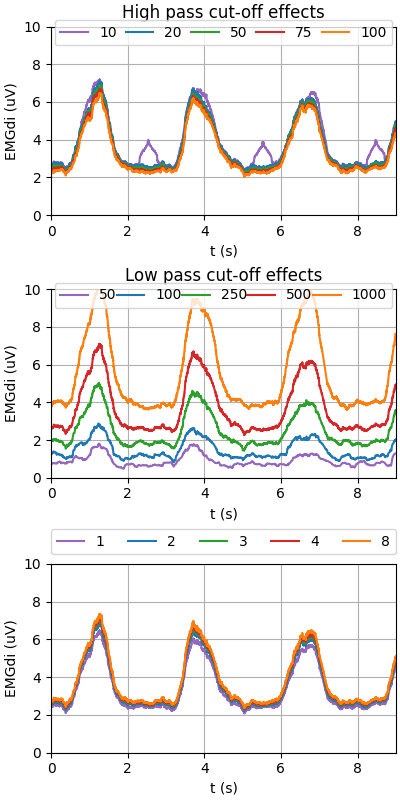

In [6]:
# Iterate over low- and high-pass cut-off frequency
fig = plt.figure(layout="constrained", figsize=(4, 8))

gs = GridSpec(6, 1, figure=fig)
axes_emg_2 = fig.add_subplot(gs[:2])
axes_emg_1 = fig.add_subplot(gs[2:4], sharex=axes_emg_2)
axes_emg_3 = fig.add_subplot(gs[4:], sharex=axes_emg_2)

emg_timeseries.run('get_ecg_peaks', overwrite=True)

# EMG data
# - Bandpass hp_cf: 10-100, lp_cf 50 - 1000
lp_cfs = [50, 100, 250, 500, 1000]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']

for _, (lp_cf, color) in enumerate(zip(lp_cfs, colors)):
    emg_timeseries[1].filter_emg(lp_cf=lp_cf)
    emg_timeseries[1]
    emg_timeseries[1].gating(
        gate_width_samples=fs_emg//5,
    )
    emg_timeseries[1].envelope()
    emg_timeseries[1].plot_full(
        axes=axes_emg_1,
        signal_io=('env',),
        baseline_bool=False,
        colors=[color])
axes_emg_1.set_xlabel('t (s)')
axes_emg_1.set_ylim([0, y_lim])
axes_emg_1.set_title('Low pass cut-off effects')
axes_emg_1.legend(
    [str(lp_cf) for lp_cf in lp_cfs],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)


# - Bandpass hp_cf: 10-100, lp_cf 50 - 1000
hp_cfs = [10, 20, 50, 75, 100]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']

for _, (hp_cf, color) in enumerate(zip(hp_cfs, colors)):
    # emg_timeseries[1].filter_emg(hp_cf=hp_cf, order=1)
    emg_timeseries[1].filter_emg(hp_cf=hp_cf)
    emg_timeseries[1].gating(
        gate_width_samples=fs_emg//5,
    )
    emg_timeseries[1].envelope()
    emg_timeseries[1].plot_full(
        axes=axes_emg_2,
        signal_io=('env',),
        baseline_bool=False,
        colors=[color])
axes_emg_2.set_xlabel('t (s)')
axes_emg_2.set_ylim([0, y_lim])
axes_emg_2.set_title('High pass cut-off effects')
axes_emg_2.legend(
    [str(hp_cf) for hp_cf in hp_cfs],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)


# Orders
orders = [1, 2, 3, 4, 8]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']

for _, (order, color) in enumerate(zip(orders, colors)):
    emg_timeseries[1].filter_emg(order=order)
    emg_timeseries[1].gating(gate_width_samples=fs_emg//5)
    emg_timeseries[1].envelope()
    emg_timeseries[1].plot_full(
        axes=axes_emg_3,
        signal_io=('env',),
        baseline_bool=False,
        colors=[color])
# bbox_to_anchor=(0., -0.6, 1., -.6),
axes_emg_3.legend(
    [str(order) for order in orders], 
    bbox_to_anchor=(0., 1.05, 1., 1.05),
    loc='lower left',
    ncols=5, 
    mode="expand",
    borderaxespad=0.)
axes_emg_3.set_xlabel('t (s)')
axes_emg_3.set_ylim([0, y_lim])
axes_emg_3.set_xlabel('t (s)')
axes_emg_3.set_xlim([0, x_lim])


In [7]:
# Filter
emg_timeseries.run(
    'filter_emg',
    lp_cf=500,
    hp_cf=20,
    order=3,
)

# 4. ECG-removal

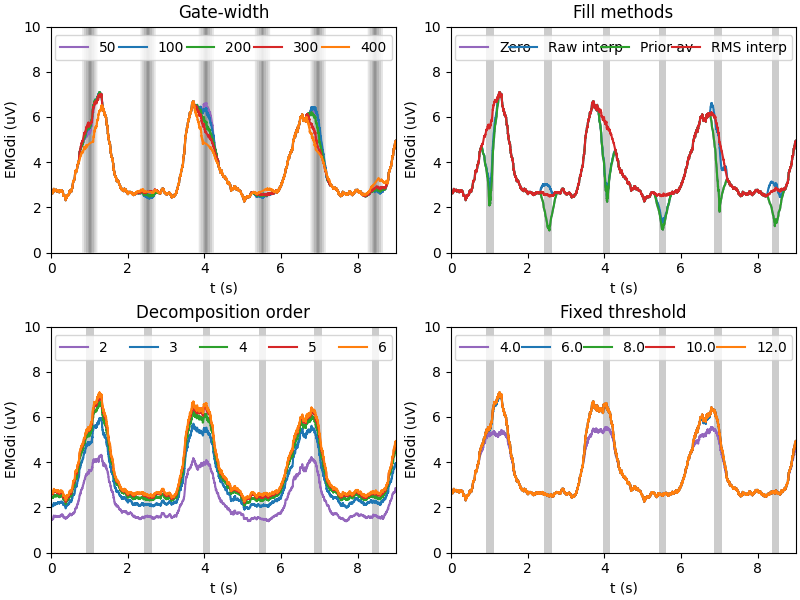

In [ ]:
# Side plot
fig = plt.figure(layout="constrained", figsize=(8, 6))

gs = GridSpec(6, 2, figure=fig)
axes_emg_1 = fig.add_subplot(gs[:3, 0])
axes_emg_2 = fig.add_subplot(gs[:3, 1], sharex=axes_emg_1)
axes_emg_3 = fig.add_subplot(gs[3:, 0], sharex=axes_emg_1)
axes_emg_4 = fig.add_subplot(gs[3:, 1], sharex=axes_emg_1)

# EMG data
# ---- Gating ----
# Iterate over window length
gate_width_t_ms = [50, 100, 200, 300, 400]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
for _, (gate_width_t, color) in enumerate(zip(gate_width_t_ms, colors)):
    emg_timeseries[1].filter_emg(
        lp_cf=500,
        hp_cf=20,
        order=3,
    )
    gate_width_t_s = (gate_width_t *  fs_emg) // 1000
    emg_timeseries[1].gating(
        gate_width_samples=gate_width_t_s,
        fill_method=3)
    emg_timeseries[1].envelope(env_window=fs_emg//4)
    emg_timeseries[1].plot_full(
        axes=axes_emg_1,
        signal_io=('env',),
        baseline_bool=False,
        colors=[color])
axes_emg_1.set_xlabel('t (s)')
axes_emg_1.set_ylim([0, y_lim])
axes_emg_1.set_title('Gate-width')
axes_emg_1.legend(
    [str(gate_t) for gate_t in gate_width_t_ms],
    bbox_to_anchor=(0.01, 0.85, 0.98, 0.85),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

peak_idxs = emg_timeseries[1].peaks['ecg']['peak_idx']
peak_idxs = peak_idxs[peak_idxs < x_lim * fs_emg] - 10
t_emg_8 = np.array(t_emg)[np.array(t_emg) < x_lim * fs_emg]

t_to_peak = (np.min(np.abs(
    repmat(peak_idxs/fs_emg, len(t_emg_8), 1) 
    - repmat(t_emg_8, len(peak_idxs), 1).T), axis=1))
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (2.5 * 2),
                color='black', alpha=0.1, edgecolor=None)
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1*3 / (10 * 2),
                color='black', alpha=0.1, edgecolor=None)
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (5 * 2),
                color='black', alpha=0.1, edgecolor=None)
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (10 * 2),
                color='black', alpha=0.1, edgecolor=None)
axes_emg_1.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (20 * 2),
                color='black', alpha=0.1, edgecolor=None)


# Iterate over gating fill methods
methods = [0, 1, 2, 3]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red']
for _, (method, color) in enumerate(zip(methods, colors)):
    emg_timeseries[1].filter_emg(
        lp_cf=500,
        hp_cf=20,
        order=3,
    )
    emg_timeseries[1].gating(
        fill_method=method,
        gate_width_samples=fs_emg//5,
    )
    emg_timeseries[1].envelope(env_window=fs_emg//4)
    emg_timeseries[1].plot_full(
        axes=axes_emg_2,
        signal_io=('env',),
        baseline_bool=False,
        colors=[color])
axes_emg_2.set_xlabel('t (s)')
axes_emg_2.set_ylim([0, y_lim])
axes_emg_2.set_title('Fill methods')
methods_legend = ['Zero', 'Raw interp', 'Prior av', 'RMS interp']
axes_emg_2.legend(
    methods_legend,
    bbox_to_anchor=(0.01, 0.85, 0.98, 0.85),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

axes_emg_2.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (5 * 2),
                color='black', alpha=0.2, edgecolor=None)


# ---- Wavelet denoising ----
# Iterate over order
orders = [2, 3, 4, 5, 6]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
for _, (order, color) in enumerate(zip(orders, colors)):
    emg_timeseries[1].filter_emg(
        lp_cf=500,
        hp_cf=20,
        order=3,
    )
    gate_width_t_s = (gate_width_t *  fs_emg) // 1000
    emg_timeseries[1].wavelet_denoising(
        n=order,
        fixed_threshold=10.0)
    emg_timeseries[1].envelope(env_window=fs_emg//4)
    emg_timeseries[1].plot_full(
        axes=axes_emg_3,
        signal_io=('env',),
        baseline_bool=False,
        colors=[color])
axes_emg_3.set_xlabel('t (s)')
axes_emg_3.set_ylim([0, y_lim])
axes_emg_3.set_title('Decomposition order')
axes_emg_3.legend(
    [str(n) for n in orders],
    bbox_to_anchor=(0.01, 0.85, 0.98, 0.85),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

peak_idxs = emg_timeseries[1].peaks['ecg']['peak_idx']
peak_idxs = peak_idxs[peak_idxs < x_lim * fs_emg] - 10
t_emg_8 = np.array(t_emg)[np.array(t_emg) < x_lim * fs_emg]

t_to_peak = (np.min(np.abs(
    repmat(peak_idxs/fs_emg, len(t_emg_8), 1) 
    - repmat(t_emg_8, len(peak_idxs), 1).T), axis=1))
axes_emg_3.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (5 * 2),
                color='black', alpha=0.2, edgecolor=None)


# Iterate over gating fill methods
fixed_thresholds = [4.0, 6.0, 8.0, 10.0, 12.0]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
for _, (fixed_threshold, color) in enumerate(zip(fixed_thresholds, colors)):
    emg_timeseries[1].filter_emg(
        lp_cf=500,
        hp_cf=20,
        order=3,
    )
    emg_timeseries[1].wavelet_denoising(
        n=6,
        fixed_threshold=fixed_threshold)
    emg_timeseries[1].envelope(env_window=fs_emg//4)
    emg_timeseries[1].plot_full(
        axes=axes_emg_4,
        signal_io=('env',),
        baseline_bool=False,
        colors=[color])
axes_emg_4.set_xlabel('t (s)')
axes_emg_4.set_ylim([0, y_lim])
axes_emg_4.set_title('Fixed threshold')
axes_emg_4.legend(
    [str(threshold) for threshold in fixed_thresholds],
    bbox_to_anchor=(0.01, 0.85, 0.98, 0.85),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

axes_emg_4.fill_between(t_emg_8, 0.0, y_lim, where=t_to_peak < 1 / (5 * 2),
                        color='black', alpha=0.2, edgecolor=None)



axes_emg_1.set_xlim([0, x_lim])
axes_emg_1.grid(False)
axes_emg_2.grid(False)
axes_emg_3.grid(False)
axes_emg_4.grid(False)

# 5. Envelope

In [9]:
# Gate the EMG
emg_timeseries.run(
    'filter_emg',
    lp_cf=500,
    hp_cf=20,
    order=3,
)
emg_timeseries.run('gating', gate_width_samples=fs_emg//5)


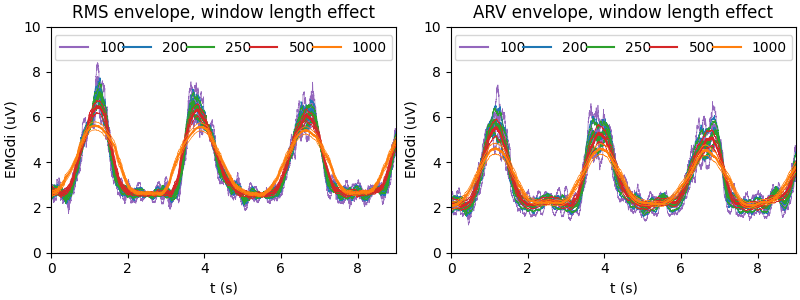

In [10]:
# Compare envelope methods

# Side plot
fig = plt.figure(layout="constrained", figsize=(8, 3))

gs = GridSpec(3, 2, figure=fig)
axes_emg_1 = fig.add_subplot(gs[:3, 0])
axes_emg_2 = fig.add_subplot(gs[:3, 1], sharex=axes_emg_1, sharey=axes_emg_1)

# EMG data
# RMS windows
rms_windows = [100, 200, 250, 500, 1000]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
for idx, (rms_window, color) in enumerate(zip(rms_windows, colors)):
    emg_timeseries[1].envelope(
        env_type='rms', 
        env_window=(rms_window * fs_emg) // 1000,
        ci_alpha=0.05)
    emg_timeseries[1].plot_full(
        axes=axes_emg_1,
        signal_io=('env',),
        baseline_bool=False,
        colors=[color],
        plot_ci=False)
    axes_emg_1.plot(emg_timeseries[1].t_data,
                    np.transpose(emg_timeseries[1]['env_ci']),
                    color=colors[idx], linewidth=0.5)
axes_emg_1.set_xlabel('t (s)')
axes_emg_1.set_ylim([0, y_lim])
axes_emg_1.set_title('RMS envelope, window length effect')
axes_emg_1.legend(
    axes_emg_1.lines[::3],
    [str(rms_window) for rms_window in rms_windows],
    bbox_to_anchor=(0.01, 0.85, 0.98, 0.85),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)


# ARV windows
arv_windows = [100, 200, 250, 500, 1000]
colors = ['tab:purple', 'tab:blue', 'tab:green', 'tab:red', 'tab:orange']
for idx, (arv_window, color) in enumerate(zip(arv_windows, colors)):
    emg_timeseries[1].envelope(
        env_type='arv', 
        env_window=(arv_window * fs_emg) // 1000,
        ci_alpha=0.05)
    emg_timeseries[1].plot_full(
        axes=axes_emg_2,
        signal_io=('env',),
        baseline_bool=False,
        colors=[color],
        plot_ci=False)
    axes_emg_2.plot(emg_timeseries[1].t_data,
                    np.transpose(emg_timeseries[1]['env_ci']),
                    color=colors[idx], linewidth=0.5)
axes_emg_2.set_xlabel('t (s)')
axes_emg_2.set_ylim([0, y_lim])
axes_emg_2.set_title('ARV envelope, window length effect')
axes_emg_2.legend(
    axes_emg_2.lines[::3],
    [str(arv_window) for arv_window in arv_windows],
    bbox_to_anchor=(0.01, 0.85, 0.98, 0.85),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

axes_emg_1.set_xlim([0, x_lim])
axes_emg_1.grid(False)
axes_emg_2.grid(False)

In [11]:
# Calculate the envelope of the signal
emg_timeseries.run('envelope', ci_alpha=0.05)

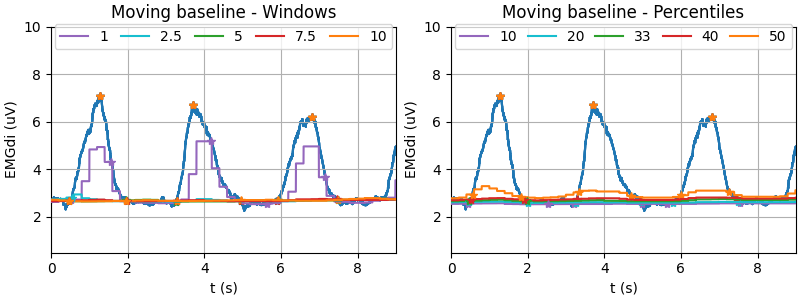

In [12]:
# Compare baseline methods - On- and offset detection

# Side plot
fig = plt.figure(layout="constrained", figsize=(8, 3))

gs = GridSpec(3, 2, figure=fig)
axes_emg_1 = fig.add_subplot(gs[:3, 0])
axes_emg_2 = fig.add_subplot(gs[:3, 1], sharex=axes_emg_1)

N_plots = 11

# EMG data
emg_di = emg_timeseries[1]
# Moving baseline - windows
bl_windows = [1, 2.5, 5, 7.5, 10]
colors = ['tab:purple', 'tab:cyan', 'tab:green', 'tab:red', 'tab:orange']
for _, (bl_window, color) in enumerate(zip(bl_windows, colors)):
    emg_timeseries[1].baseline(
        percentile=33,
        window_s=int(bl_window * fs_emg))
    emg_di.detect_emg_breaths(
        peak_set_name='breaths',
        end_idx = int(x_lim * fs_emg),
        prominence_factor = 1.5,
        overwrite=True)
    emg_di.peaks['breaths'].detect_on_offset(
        baseline=emg_di['baseline']
    )
    emg_timeseries[1].plot_full(
        axes=axes_emg_1,
        signal_io=('env',),
        baseline_bool=True,
        colors=['tab:blue', color])
    emg_di.plot_markers(peak_set_name='breaths', axes=axes_emg_1, colors=color)
axes_emg_1.set_xlabel('t (s)')
axes_emg_1.set_ylim([0.5, y_lim])
axes_emg_1.set_title('Moving baseline - Windows')
axes_emg_1.legend(
    [axes_emg_1.lines[i*N_plots+1] for i in range(len(bl_windows))],
    [str(bl_window) for bl_window in bl_windows],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

for line in [axes_emg_1.lines[i*N_plots] for i in range(len(bl_windows))]:
    line.set_zorder(0)

for line in [axes_emg_1.lines[i*N_plots+1] for i in range(len(bl_windows))]:
    line.set_zorder(5)

for line in [axes_emg_1.lines[i*N_plots+2] for i in range(len(bl_windows))]:
    line.set_zorder(10)

for line in [axes_emg_1.lines[i*N_plots+3] for i in range(len(bl_windows))]:
    line.set_zorder(10)

for line in [axes_emg_1.lines[i*N_plots+4] for i in range(len(bl_windows))]:
    line.set_zorder(10)

# Moving baseline - percentiles
bl_percentiles = [10, 20, 33, 40, 50]
colors = ['tab:purple', 'tab:cyan', 'tab:green', 'tab:red', 'tab:orange']
for _, (bl_percentile, color) in enumerate(zip(bl_percentiles, colors)):
    emg_timeseries.run(
        'baseline',
        percentile=bl_percentile,
        window_s=int(7.5 * fs_emg))
    emg_di.detect_emg_breaths(
        peak_set_name='breaths',
        end_idx = int(x_lim * fs_emg),
        prominence_factor=1.0,
        overwrite=True)
    emg_di.peaks['breaths'].detect_on_offset(
        baseline=emg_di['baseline']
    )
    emg_timeseries[1].plot_full(
        axes=axes_emg_2,
        signal_io=('env',),
        baseline_bool=True,
        colors=['tab:blue', color])
    emg_di.plot_markers(peak_set_name='breaths', axes=axes_emg_2, colors=color)
axes_emg_2.set_xlabel('t (s)')
axes_emg_2.set_ylim([0.5, y_lim])
axes_emg_2.set_title('Moving baseline - Percentiles')
axes_emg_2.legend(
    [axes_emg_2.lines[i*N_plots+1] for i in range(len(bl_percentiles))],
    [str(bl_percentile) for bl_percentile in bl_percentiles],
    bbox_to_anchor=(0.01, 0.90, 0.98, 0.90),
    loc='lower left',
    ncols=5, 
    mode="expand", borderaxespad=0.)

axes_emg_2.set_xlim([0, x_lim])

for line in [axes_emg_2.lines[i*N_plots] for i in range(len(bl_percentiles))]:
    line.set_zorder(0)

for line in [axes_emg_2.lines[i*N_plots+1] for i in range(len(bl_percentiles))]:
    line.set_zorder(5)

for line in [axes_emg_2.lines[i*N_plots+2] for i in range(len(bl_percentiles))]:
    line.set_zorder(10)

for line in [axes_emg_2.lines[i*N_plots+3] for i in range(len(bl_percentiles))]:
    line.set_zorder(10)

for line in [axes_emg_2.lines[i*N_plots+4] for i in range(len(bl_percentiles))]:
    line.set_zorder(10)


In [13]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.run('baseline')
emg_di.detect_emg_breaths(
        peak_set_name='breaths',
        end_idx = int(x_lim * fs_emg),
        prominence_factor=1.0,
        overwrite=True)
emg_di.peaks['breaths'].detect_on_offset(
    baseline=emg_di['baseline']
)

In [14]:
# Find supported breath pressures
vent_timeseries[0].baseline(
    signal_io=('raw', 'baseline'),
    percentile=50)
vent_timeseries[2].baseline(
    signal_io=('raw', 'baseline'),
    percentile=33)

p_vent = vent_timeseries.channels[vent_timeseries.p_vent_idx]
v_vent = vent_timeseries.channels[vent_timeseries.v_vent_idx]
vent_timeseries.find_tidal_volume_peaks(
    start_idx=0,
    end_idx=int(x_lim*fs_emg),
    overwrite=True
)
p_vent.peaks['ventilator_breaths'].detect_on_offset(
    baseline=p_vent['baseline'])
v_vent.peaks['ventilator_breaths'].detect_on_offset(
    baseline=v_vent['baseline'])

In [15]:
# Find the EMG peaks with the peak timing closest to the Pocc timings, and
# link ventilator Pocc peaks to EMG breaths
t_breaths_peaks_vent = p_vent.peaks['ventilator_breaths']['peak_idx'] / p_vent.param['fs']

emg_di.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_breaths_peaks_vent,
    linked_peak_set_name='breaths_linked',
)

(0.0, 9.0)

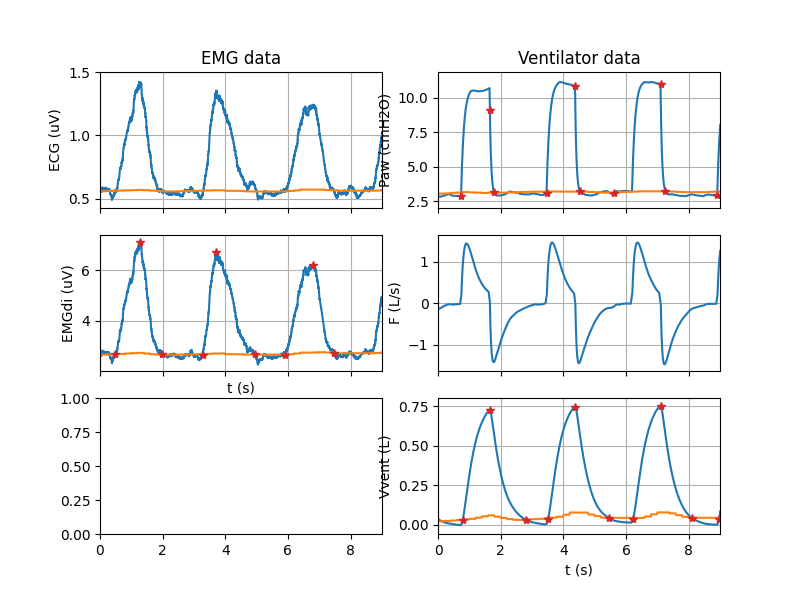

In [16]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(8, 6), sharex=True)
axes_emg = axis[:2, 0]
emg_timeseries.run('plot_full', axes=axes_emg, signal_io=('env',))
emg_di.plot_markers(peak_set_name='breaths', axes=axes_emg[1])

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# Ventilator data data
axes_vent = axis[:, 1]
vent_timeseries.run('plot_full', axes=axes_vent)
p_vent.plot_markers(peak_set_name='ventilator_breaths', axes=axes_vent[0])
v_vent.plot_markers(peak_set_name='ventilator_breaths', axes=axes_vent[2])
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')
axes_vent[-1].set_xlim([0, x_lim])

In [17]:
# Calculate ETPdi
emg_di.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')

print(emg_di.peaks['breaths'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi
0      2590        980     4085   True  0.661280   2.255549  3.614410
1      7596       6706    10153   True  0.712343   2.255549  3.765416
2     13934      12087    15301   True  0.733400   2.255549  3.536593


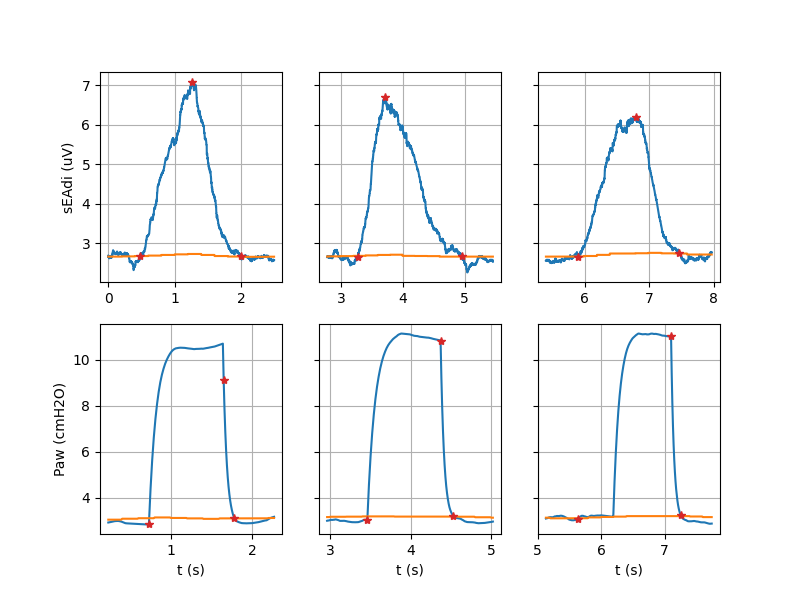

In [18]:
# Plot the individual peaks
n_peaks = len(emg_di.peaks['breaths'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(8, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='breaths')
    
emg_di.plot_markers(axes=axes_emg, peak_set_name='breaths')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='ventilator_breaths')
p_vent.plot_markers(axes=axes_vent, peak_set_name='ventilator_breaths')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

# 6. Test Pocc and sEMG quality of the peaks

In [19]:
# Test EMG quality
parameter_names = {
    'time_product': 'ETPdi'
}
emg_di.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)

# The peak-validity is updated in the peak_df:
print(emg_di.peaks['breaths'].quality_values_df)
print(emg_di.peaks['breaths'].quality_outcomes_df)

   peak_idx       snr        aub  aub_y_refs       bell
0      2590  2.656660  18.295654    2.255549   8.266113
1      7596  2.506556  18.918034    2.255549  12.779795
2     13934  2.265728  20.737470    2.255549   5.945824
   baseline_detection  peak_idx  interpeak_distance   snr   aub  bell  \
0                True      2590                True  True  True  True   
1                True      7596                True  True  True  True   
2                True     13934                True  True  True  True   

   relative_aub  relative_etp  
0          True          True  
1          True          True  
2          True          True  


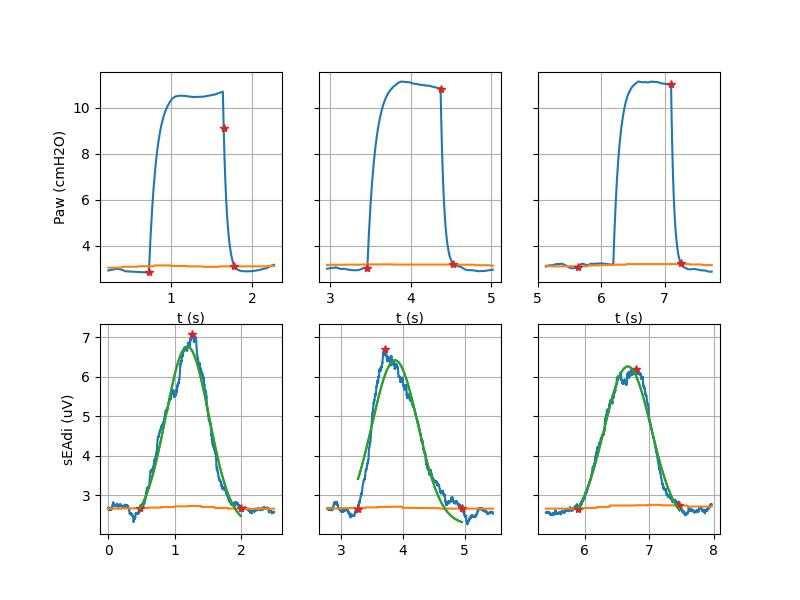

In [20]:
# Plot the individual peaks bell-fit
n_peaks = len(emg_di.peaks['breaths'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(8, 6), sharey='row')

axes_emg = axis[1, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='breaths')
emg_di.plot_markers(axes=axes_emg, peak_set_name='breaths')
emg_di.plot_curve_fits(axes=axes_emg, peak_set_name='breaths')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[0, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='ventilator_breaths')
p_vent.plot_markers(axes=axes_vent, peak_set_name='ventilator_breaths')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

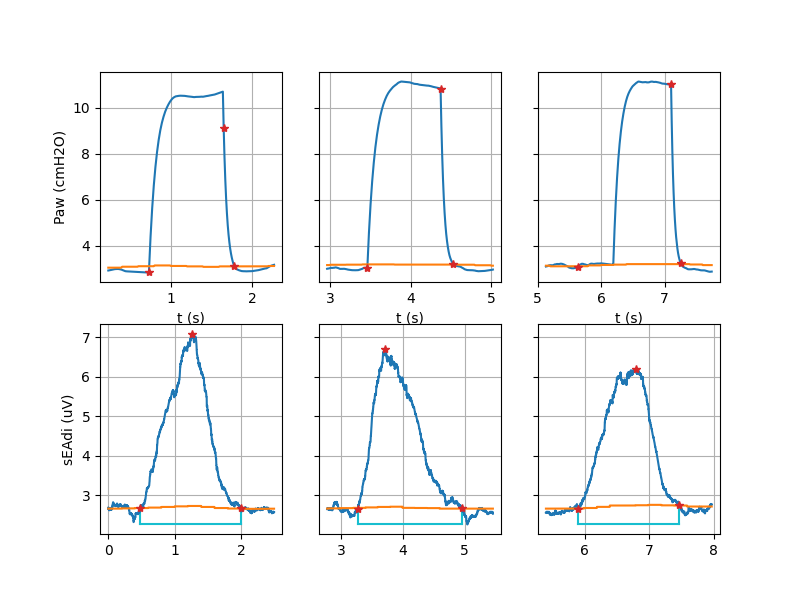

In [21]:
# Plot the individual peaks bell-fit
n_peaks = len(emg_di.peaks['breaths'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(8, 6), sharey='row')

axes_emg = axis[1, :]
emg_di.plot_aub(axes=axes_emg, signal_io=('env',), peak_set_name='breaths')
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='breaths')
emg_di.plot_markers(axes=axes_emg, peak_set_name='breaths')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[0, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='ventilator_breaths')
p_vent.plot_markers(axes=axes_vent, peak_set_name='ventilator_breaths')

for axis in axes_vent:
    axis.set_xlabel('t (s)')